# P2 Continuous Control

In [1]:
from collections import deque
from unityagents import UnityEnvironment

## Open environment and view the space

In [2]:
# Instantiate the Unity environment with the reacher simulation of 20 agents
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]      
action_size = brain.vector_action_space_size     
state = env_info.vector_observations[0]
state_size = len(state)
print("State space:", state_size, "\nAction space", action_size, "\n Initial State ", state )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


State space: 33 
Action space 4 
 Initial State  [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Run while training agent

In [3]:
import torch
import numpy as np

def run(n_episodes=300, save_every=10, steps_to_learn=15, update_learn=20):
    scores_moving_win = deque(maxlen=100)
    total_scores = []
    for i_episode in range(1, n_episodes+1):
        scores = np.zeros(20) #One score per agent
        #scores = np.empty(20)
        env_info = env.reset(train_mode=True)[brain_name] 
        states = env_info.vector_observations
        #print(states)
        agent.reset()
        t = 0
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]      
            next_states = env_info.vector_observations            
            rewards = env_info.rewards
            scores += rewards
            dones = env_info.local_done 
            for i in range(len(states)):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            states = next_states
            if t%steps_to_learn == 0:
                for _ in range(update_learn):
                    agent.learn()
            if np.all(dones):                                  # exit loop if all episodes finished
                break
            t += 1

        mean_score = np.mean(scores)
        scores_moving_win.append(mean_score)
        total_scores.append(mean_score)
        average_score_moving_win = np.mean(scores_moving_win)
        
        print('\rEpisode {}\tAverage Score: {:.2f} \t Min:{:.2f} \t Max:{:.2f}'.format(
            i_episode, average_score_moving_win,
            np.min(scores), np.max(scores)), end="")

        if i_episode % save_every == 0:
            print()
            torch.save(agent.actor_local.state_dict(), 'checkpoint_{}_actor.pth'.format(i_episode))
            torch.save(agent.critic_local.state_dict(), 'checkpoint_{}_critic.pth'.format(i_episode) )
        
        if (average_score_moving_win >=30) and (len(scores_moving_win)==100):
            print("\nReached train condition by episode {}!".format(i_episode))
            torch.save(agent.actor_local.state_dict(), 'final_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'final_critic.pth')
            break
    return total_scores

In [4]:
#Run Training
#Instantiate critic and actor 
from agent import Agent

agent = Agent(state_size=state_size, action_size=action_size)
scores = run()

cuda:0
Episode 10	Average Score: 1.52 	 Min:1.04 	 Max:6.32
Episode 20	Average Score: 3.94 	 Min:5.09 	 Max:13.84
Episode 30	Average Score: 8.21 	 Min:11.68 	 Max:28.93
Episode 40	Average Score: 13.13 	 Min:14.59 	 Max:39.61
Episode 50	Average Score: 17.30 	 Min:25.78 	 Max:39.48
Episode 60	Average Score: 20.50 	 Min:34.53 	 Max:39.36
Episode 70	Average Score: 22.84 	 Min:29.23 	 Max:39.47
Episode 80	Average Score: 24.66 	 Min:27.44 	 Max:39.39
Episode 90	Average Score: 25.98 	 Min:34.15 	 Max:39.32
Episode 100	Average Score: 27.04 	 Min:32.82 	 Max:39.14
Episode 109	Average Score: 30.26 	 Min:29.26 	 Max:39.49
Reached train condition by episode 109!


## Plot run results

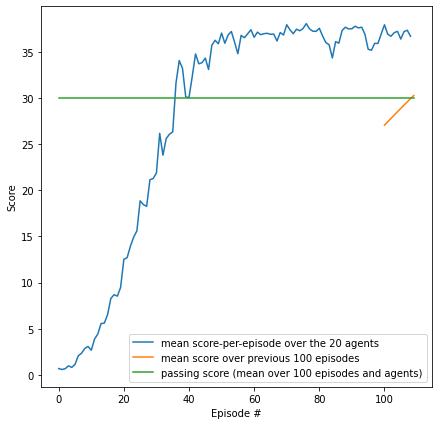

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
N_smooth = 100
smoothed_scores = np.convolve(scores, np.ones(N_smooth)/N_smooth, 'valid')
plt.plot(N_smooth + np.arange(len(smoothed_scores)), smoothed_scores)
plt.plot([0,len(scores)],[30, 30])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['mean score-per-episode over the 20 agents',
            'mean score over previous 100 episodes',
            'passing score (mean over 100 episodes and agents)'])
plt.show()

In [13]:
env.close()